In [1]:
spark

In [2]:
infile = 'file:///home/cloudera/2.kkbox_churn/raw_data/transactions.csv'
df0 = spark.read.format('csv').option('header','true').load(infile) \
   .withColumnRenamed('payment_method_id', 'pay_method') \
   .withColumnRenamed('payment_plan_days', 'plan_days') \
   .withColumnRenamed('plan_list_price', 'list_price') \
   .withColumnRenamed('actual_amount_paid', 'actual_paid') \
   .withColumnRenamed('transaction_date', 'transac_date') \
   .withColumnRenamed('membership_expire_date', 'expire_date')
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- pay_method: string (nullable = true)
 |-- plan_days: string (nullable = true)
 |-- list_price: string (nullable = true)
 |-- actual_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transac_date: string (nullable = true)
 |-- expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)



In [5]:
df0.show(3)

+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|                msno|pay_method|plan_days|list_price|actual_paid|is_auto_renew|transac_date|expire_date|is_cancel|
+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|YyO+tlZtAXYXoZhNr...|        41|       30|       129|        129|            1|    20150930|   20151101|        0|
|AZtu6Wl0gPojrEQYB...|        41|       30|       149|        149|            1|    20150930|   20151031|        0|
|UkDFI97Qb6+s2LWci...|        41|       30|       129|        129|            1|    20150930|   20160427|        0|
+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
only showing top 3 rows



In [3]:
# filter: 1. not is_cancel
#         2. trans. date >= 2015-11-01
from pyspark.sql.functions import col
df1 = df0.where(col('is_cancel') == '0').where(col('transac_date') >= '20151101') \
  .withColumn('plan_days1', col('plan_days').cast('int')) \
  .drop('is_cancel').drop('plan_days')

In [4]:
# compute start date
from datetime import datetime, timedelta
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, col

def get_start_date(exp_date_yyyymmdd, plan_days):
    '''
    `plan_days` should be > 0.
    Returns a string.
    '''
    d_exp = datetime.strptime(exp_date_yyyymmdd, '%Y%m%d')
    d_start = d_exp - timedelta(days=(plan_days-1))
    s = d_start.strftime('%Y%m%d')
    return s

udf_get_start_date = udf(get_start_date, StringType())

df2 = df1.withColumn('start_date', udf_get_start_date(col('expire_date'), col('plan_days1')))
df2.show(10)

+--------------------+----------+----------+-----------+-------------+------------+-----------+----------+----------+
|                msno|pay_method|list_price|actual_paid|is_auto_renew|transac_date|expire_date|plan_days1|start_date|
+--------------------+----------+----------+-----------+-------------+------------+-----------+----------+----------+
|FT4moGxOj6tzwkTSA...|        34|       149|        149|            1|    20151130|   20151231|        30|  20151202|
|z1s1E/gm6xiwjNb8T...|        34|       149|        149|            1|    20151130|   20151231|        30|  20151202|
|lZyYiuAJW3qzDnicN...|        34|       149|        149|            1|    20151130|   20151231|        30|  20151202|
|pXpFcJbT8/FDkhnSU...|        34|       149|        149|            1|    20151130|   20151231|        30|  20151202|
|0f9IUy6wP6pEUntXg...|        31|       149|        149|            1|    20151130|   20151231|        30|  20151202|
|CAtxj/lcQ2WNyVwuO...|        33|       149|        149|

In [5]:
# compare trans. date with start date
from pyspark.sql.functions import col, datediff, to_date
df3 = df2.withColumn('start_minus_trans',  
                     datediff(to_date('start_date', 'yyyyMMdd'),
                              to_date('transac_date', 'yyyyMMdd')
                             )
                    )
df3.drop('is_auto_renew').drop('list_price').show(10)

+--------------------+----------+-----------+------------+-----------+----------+----------+-----------------+
|                msno|pay_method|actual_paid|transac_date|expire_date|plan_days1|start_date|start_minus_trans|
+--------------------+----------+-----------+------------+-----------+----------+----------+-----------------+
|FT4moGxOj6tzwkTSA...|        34|        149|    20151130|   20151231|        30|  20151202|                2|
|z1s1E/gm6xiwjNb8T...|        34|        149|    20151130|   20151231|        30|  20151202|                2|
|lZyYiuAJW3qzDnicN...|        34|        149|    20151130|   20151231|        30|  20151202|                2|
|pXpFcJbT8/FDkhnSU...|        34|        149|    20151130|   20151231|        30|  20151202|                2|
|0f9IUy6wP6pEUntXg...|        31|        149|    20151130|   20151231|        30|  20151202|                2|
|CAtxj/lcQ2WNyVwuO...|        33|        149|    20151130|   20151231|        30|  20151202|                2|
|

# start_date - transac_date

In [42]:
from pyspark.sql.functions import min, max
df3.select(min('start_minus_trans'), max('start_minus_trans')).show()

+----------------------+----------------------+
|min(start_minus_trans)|max(start_minus_trans)|
+----------------------+----------------------+
|                -17563|                   487|
+----------------------+----------------------+



In [6]:
from prepare_hist_data import prepare_histogram_data
rdd = df3.rdd.map(lambda row: row['start_minus_trans'])
rdd.persist()
Nrec = rdd.count()
print(Nrec)

14254984


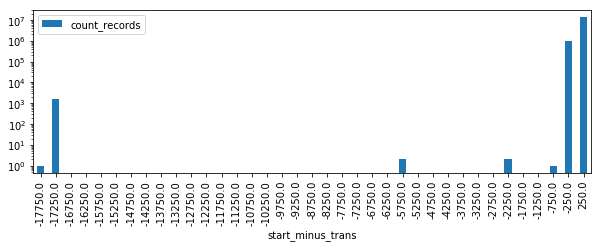

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
hist_data = prepare_histogram_data(rdd, -18000, 500, 37)
pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_records']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar', logy=True, figsize=(10,3))
plt.show()

In [8]:
rdd.filter(lambda v: v<(-356*40)).count()

# number of records with (start date) < (transaction date - 40 yr) :

1528

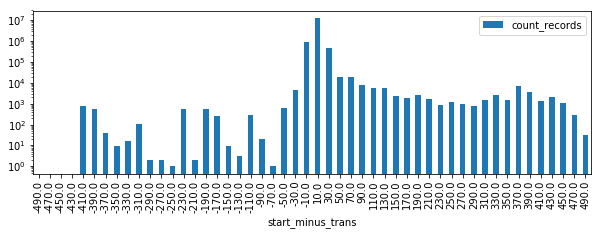

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
hist_data = prepare_histogram_data(rdd, -500, 500, 50)
pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_records']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar', logy=True, figsize=(10,3))
plt.show()

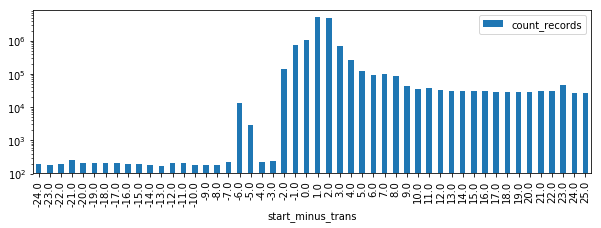

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
hist_data = prepare_histogram_data(rdd, -24.5, 25.5, 50)
pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_records']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar', logy=True, figsize=(10,3))
plt.show()

# start_date - transac_date < -40 yr

In [11]:
from pyspark.sql.functions import col
df4 = df3.where(col('start_minus_trans') < (-365*40)).persist()
df4.count()  

1528

In [18]:
df4.drop('start_minus_trans').show(20)

+--------------------+----------+----------+-----------+-------------+------------+-----------+----------+----------+
|                msno|pay_method|list_price|actual_paid|is_auto_renew|transac_date|expire_date|plan_days1|start_date|
+--------------------+----------+----------+-----------+-------------+------------+-----------+----------+----------+
|feoqKszFUCDjm6c4n...|        17|         0|          0|            0|    20170129|   19700101|        60|  19691103|
|W27NhBZTYj1B/InWG...|        17|         0|          0|            0|    20170205|   19700101|        60|  19691103|
|q/4Lm0XD+X6nSAlAh...|        17|         0|          0|            0|    20170121|   19700101|        60|  19691103|
|sa2BaBSzbcdHRoz6E...|        17|         0|          0|            0|    20170118|   19700101|       120|  19690904|
|w3PkMX9MEoG3eJkUq...|        17|         0|          0|            0|    20170126|   19700101|       120|  19690904|
|CUtddnWdKTgvpGzzu...|        17|         0|          0|

In [21]:
from pyspark.sql.functions import col
df4.groupBy('expire_date').count().show()

+-----------+-----+
|expire_date|count|
+-----------+-----+
|   19700101| 1528|
+-----------+-----+



In [20]:
df4.groupBy('pay_method').count().show()

+----------+-----+
|pay_method|count|
+----------+-----+
|        35|    1|
|        17| 1512|
|        32|   13|
|        13|    2|
+----------+-----+



In [23]:
df4.groupBy('plan_days1').count().show()

+----------+-----+
|plan_days1|count|
+----------+-----+
|       120|  272|
|         7|    1|
|       240|  534|
|       195|    1|
|        60|  706|
|       410|    1|
|       180|   13|
+----------+-----+



In [24]:
df4.groupBy('list_price').count().show()

+----------+-----+
|list_price|count|
+----------+-----+
|       894|    1|
|      1788|    1|
|         0| 1513|
|       699|   13|
+----------+-----+



In [25]:
df4.groupBy('actual_paid').count().show()

+-----------+-----+
|actual_paid|count|
+-----------+-----+
|        894|    1|
|       1788|    1|
|          0| 1513|
|        699|   13|
+-----------+-----+



In [26]:
df4.groupBy('is_auto_renew').count().show()

+-------------+-----+
|is_auto_renew|count|
+-------------+-----+
|            0| 1528|
+-------------+-----+



In [31]:
from pyspark.sql.functions import col, floor
df4.groupBy(floor(col('transac_date').cast('int')/100).alias('month')).count() \
  .sort('month').show()

+------+-----+
| month|count|
+------+-----+
|201603|   11|
|201604|    2|
|201608|    1|
|201612|    2|
|201701| 1104|
|201702|  408|
+------+-----+



**Finding.** start_date $-$ transac_date $< -40$ yr
* $\implies$ expire_date = 1970-01-01, is_auto_renew = 0
* mostly have pay_method = 17, list_price = 0, actual_paid = 0
* mostly happen in 2017/01 and 2017/02

In [32]:
df0.where(col('msno').startswith('g4uY8SDaZK2Wr9eBO')).sort('transac_date').show()

# a member with a record with (start_date - transac_date) < -40 yr :
# (see the 2nd-to-last record)

+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|                msno|pay_method|plan_days|list_price|actual_paid|is_auto_renew|transac_date|expire_date|is_cancel|
+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|g4uY8SDaZK2Wr9eBO...|        25|       30|       150|        150|            0|    20150217|   20150319|        0|
|g4uY8SDaZK2Wr9eBO...|        25|       30|       150|        150|            0|    20150316|   20150418|        0|
|g4uY8SDaZK2Wr9eBO...|        28|       30|       150|        150|            0|    20150417|   20150518|        0|
|g4uY8SDaZK2Wr9eBO...|        28|       30|       150|        150|            0|    20150519|   20150618|        0|
|g4uY8SDaZK2Wr9eBO...|        28|       30|       150|        150|            0|    20150625|   20150725|        0|
|g4uY8SDaZK2Wr9eBO...|        28|       30|       150|        150|      

In [34]:
df0.where(col('msno').startswith('WBvn2GFE6aXDWR9S1')).sort('transac_date').show(30)

# another member with a record with (start_date - transac_date) < -40 yr :
# (see the 3rd-to-last record)

+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|                msno|pay_method|plan_days|list_price|actual_paid|is_auto_renew|transac_date|expire_date|is_cancel|
+--------------------+----------+---------+----------+-----------+-------------+------------+-----------+---------+
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|            0|    20150107|   20150206|        0|
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|            0|    20150209|   20150311|        0|
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|            0|    20150312|   20150411|        0|
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|            0|    20150416|   20150516|        0|
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|            0|    20150517|   20150616|        0|
|WBvn2GFE6aXDWR9S1...|        38|       30|       149|        149|      